In [47]:
NAME = "Paul de Graaf"
COLLABORATORS = "Luc de Vries"

---

# Python assignment Data Science 


|Name|SNR|ANR|
|----|---|----|
|Paul de Graaf|2026405|u663408|
|Luc de Vries|2024422|u940400|






# Research question 


What is the life satisfaction of countries in the Eurostat Database in 2017 and how do life satisfaction and real gdp per capita relate to each other?

# Motivation 

Life satisfaction is only measured every five years. Therefore, the measurement doesn't measure in the years between and can miss important changes in the life satisfaction. It is important to know the life satisfaction of inhabitant as this should be one of the main objectives of governmental policy. If the lifesatisfaction in our model suddenly increases massively, it can suggest that there is a problem within society that should be taken action against. The influence of this problem would otherwise not be found out until the once-per-five-year-investigation.

# Method


We will use a neural network to predict the life satisfaction of the countries, based on variables that are measured yearly.
These variables are variables that intuitively have an influence on life satisfaction, such a GDP per capita and crime rates. We will also prove that these variables are actually usefull in influencing life satisfaction. 
We will use 8 explanatory variables. These are crime rates, real GDP per capita, emissions, expenses of country on social security, unmet needs for medicare , early leavers at schools, jobsecurity and the paygap between of gender in percentages. Data will be collected from the eurostat databases. Life satisfaction is only measured in 2013 and 2018. We will try to predict the results for 2017. 

Crime rates, real gdp per capita, expenses of country on social security, unmet needs for medicare and jobsecurity are quite logical explanations for life satisfactions. We will explain in more detail the other less common used variables. First, the emmissions per capita doesn't only capture the air quality, but is also a indicator to which extent the government cares for the quality of living for current and future generations in multiple ways, such as clean streets, parks etc. Secondly, early leavers at school is an estimation of eduction levels. We chose this variable as eduction levels are not measured every year by eurostat and when people leave school more frequently the education levels are lower. Lastly, the paygap of gender in percentages is a indicator of equality in the country. In this case between men and women, but can also indicate the lengths of which the governments strives to equality at different areas such as discrimination. 

These variables will be used in a neural network that tries to predict the life satisfaction by one decimal. There are some individual countries who are missing some values. These are filled using a normal distributed value. To illustrate the data and results, we first show a graph with the correlation between real gdp per capita and life satisfaction of the actual measurement in 2013 and 2018. After the prediction we show the same graph again, but with the predicted results of 2017. 

In this research we do not use an exogenous source of randomization and therefore cannot conclude that the variables causally effect life satisfaction. Although it is likely that life satisfaction doesn't influence our variables, we cannot conclude that there is not a reverse causality problem. This will be one of our major assumptions. 

We will also use the correlation between life satisfaction and real gdp per capita for a bayesian model. We will try to predict this correlation using a tanh function and the baysian model will try to predict the starting location of the graph and the spread and height of the function. 


# Preview of the answers 

In conclusion we found that the estimates for life satisfaction in 2017 are on average 7.2, with a standard deviation of around 4. They also show a similar distribution with the actual values. The bayesian model estimated that the correlation between life satisfaction times 10 and real gdp per capita is captured by this regression : tanh(gdp*0.076)*6.68+68.888. 

# Main assumption

One of the main assumptions is that the model doesn't suffer from reversed causality. This means that our explanatory  variables such as real gdp per capita should influence life satisfaction. However, life satisfaction should not influence our independent variables. 





# Python code

First we import the packages that we will need for the python code.

In [2]:
import pandas as pd   
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.patches as pl
import seaborn as sns
from scipy import stats, optimize
import random

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sn
from scipy import optimize
import pymc3 as pm
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import arviz as az

import theano
import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
plt.style.use('seaborn')
%matplotlib inline


import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm
import statsmodels.api as sm

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


This list of Eu-countries will later be used to rename the country names. 

In [3]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

We will first download our datasets from the eurostat database using these unique identifiers. 

In [4]:
lifesat = eurostat.get_data_df('ilc_pw01') # average rating of satisfaction
realgdppc = eurostat.get_data_df('sdg_08_10') # Real gdp per capita
emissionpc = eurostat.get_data_df('t2020_rd300') # greenhouse gas emissions per capita 
socialprotpc = eurostat.get_data_df('tps00100') # social protection expenditure per inhabitant

Next we make the data such that it can be used in the next parts

In [5]:
lifesat.rename({'geo\\time':'geo'},inplace=True,axis=1) # rename geo\time to geo, makes handling the data easier
lifesat = lifesat.groupby(by="geo").mean() # group per country as this is the data that we will use

In [6]:
lifesat = lifesat.reset_index() # reset the index to make sure that the melt function can read the geo columnname correctly
lifesat = lifesat.melt(id_vars= ["geo"],value_vars=np.arange(2013,2019,5),
                        var_name='year',value_name='life satisfaction')# set the values for each years in rows, this allows to combine multiple tables later

In [7]:
realgdppc.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
realgdppc = realgdppc[(realgdppc.unit == 'CLV10_EUR_HAB')] # select only a part of the dataset as growth was also in the dataset
realgdppc = realgdppc.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
realgdppc= realgdppc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2022),
                        var_name='year',value_name='Real GDP per capita')# set the values for each years in rows, this allows to combine multiple tables later

In [8]:
emissionpc.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
emissionpc = emissionpc.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
emissionpc = emissionpc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2020),
                        var_name='year',value_name='Emissions')# set the values for each years in rows, this allows to combine multiple tables later

In [9]:
socialprotpc.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
socialprotpc = socialprotpc.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
socialprotpc = socialprotpc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2020),
                        var_name='year',value_name='Social security')# set the values for each years in rows, this allows to combine multiple tables later

We will download and prepare the second set of variables from the eurostat database using these unique identifiers.

In [10]:
healthcare = eurostat.get_data_df('tespm110') # unmet needs for medical care
educ = eurostat.get_data_df('sdg_04_10') # early leavers from education
jobsecurity = eurostat.get_data_df('ilc_lvhl30') # labour transitions by employment status
crime = eurostat.get_data_df('ilc_mddw03') # crime/violence/vandalism in the area
paygap = eurostat.get_data_df('tesem180') # gender pay gab in unadjusted form

In [11]:
healthcare.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
healthcare = healthcare.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
healthcare  = healthcare [(healthcare.sex == 'T')] # only use the total and not individual sexes
healthcare= healthcare.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='Healthcare')# set the values for each years in rows, this allows to combine multiple tables later

In [12]:
educ.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
educ = educ.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
educ = educ [(educ.sex == 'T')] # only use the total and not individual sexes
educ= educ.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='educ')# set the values for each years in rows, this allows to combine multiple tables later

In [13]:
jobsecurity.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
jobsecurity = jobsecurity.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
jobsecurity = jobsecurity [(jobsecurity.sex == 'T')&(jobsecurity.trans1y == 'TO_UNE')&(jobsecurity.wstatus.isin([ 'EMP_PT',"EMP","EMP_FT"]))]# only use the total and not individual sexes and people that get employed a year later when they are employed
jobsecurity= jobsecurity.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
jobsecurity= jobsecurity.melt(id_vars= ["geo","trans1y", "wstatus"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='jobsecurity')# set the values for each years in rows, this allows to combine multiple tables later
jobsecurity = jobsecurity.groupby(by=["geo","year"]).mean() # calculate the mean per year and country
jobsecurity= jobsecurity.reset_index()# reset the index to make sure that the rows are filled


In [14]:
crime.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
crime = crime.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
crime = crime [(crime.incgrp == 'TOTAL')& (crime.hhtyp == "TOTAL")] # only use the total and not individual sexes
crime= crime.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='crime')# set the values for each years in rows, this allows to combine multiple tables later

In [15]:
paygap.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
paygap = paygap.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
paygap= paygap.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='paygap in %')# set the values for each years in rows, this allows to combine multiple tables later

We merge all datasets to get one single complete dataset "df".

In [16]:
df1=lifesat.merge(crime,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df2=df1.merge(realgdppc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df3=df2.merge(emissionpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df4=df3.merge(socialprotpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df5=df4.merge(healthcare,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df6=df5.merge(educ,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df7=df6.merge(jobsecurity,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df=df7.merge(paygap,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df.head()



,geo,year,life satisfaction,crime,Real GDP per capita,Emissions,Social security,Healthcare,educ,jobsecurity,paygap in %
0,AL,2013,NaN,NaN,3260.0,NaN,NaN,NaN,NaN,NaN,NaN
1,AT,2013,7.970049,11.3,36180.0,9.6,10375.67,0.4,7.5,3.500000,22.3
2,BE,2013,7.512500,19.4,33490.0,11.1,9528.13,1.9,11.0,3.300000,7.5
3,BG,2013,5.433099,25.8,5390.0,7.7,2301.75,8.9,12.5,3.966667,14.1
4,CH,2013,7.986221,14.5,59200.0,7.1,11328.49,1.2,5.6,1.500000,17.6


Next, we change the dataset df so that it only includes the years 2013 and 2018. These are the years in which life satisfaction is measured. Therefore, only these years can be used to make a model. 

In [17]:

df9 = df[df.year == 2013] # select only year 2013 and 2018, because life satisfaction is measured in these years
df10 = df[df.year == 2018]# select only year 2013 and 2018, because life satisfaction is measured in these years

df = pd.concat([df9,df10]) #merge 2013 and 2018
df['country'] = df['geo'].replace(eurostat_dictionary)  #replace geo by country following the eurostat dictionary to display it nice in the graph later on

We will show a graph of the actual distribution in 2013 and 2018 with real gdp per capita on the x-axis and life satisfaction on the y-axis. The same graph style will be used later on to show our predictions of 2017. 

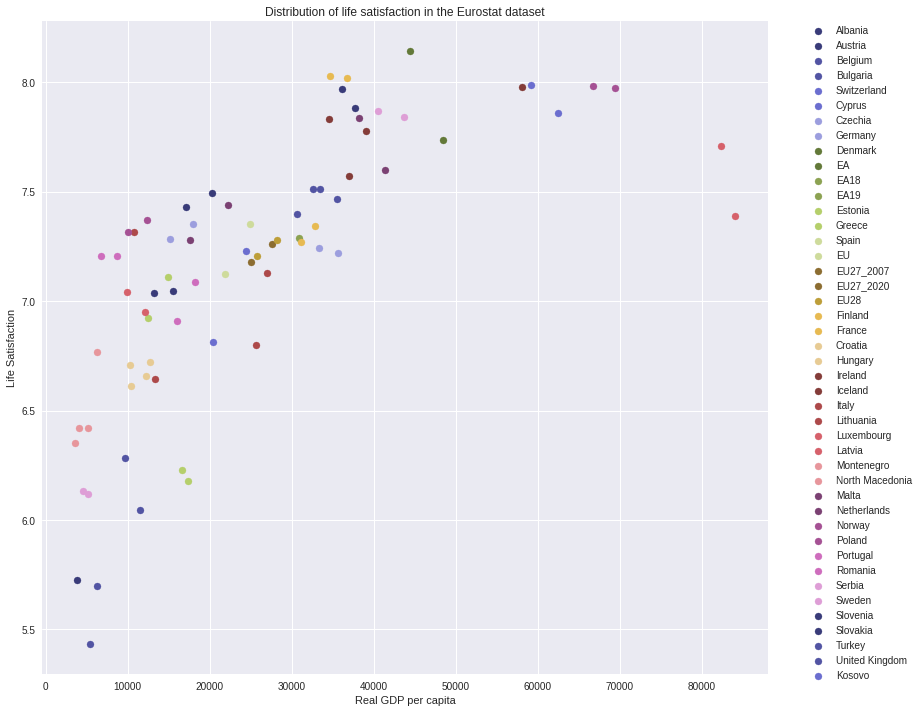

In [18]:
plt.style.use('seaborn-dark-palette')  # choise of style
NUM_COLORS = 39 # number of colors/countries used 

cm = plt.get_cmap('tab20b') # get the colormap 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)  # rescale the colors based on the numbers to get the optimal difference in colors
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm) # handles the colormap and the colors

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])) # makes sure that countries do not get the same color based on the number of colors

fig, (ax1) = plt.subplots(1, sharey=True, sharex=True,figsize=(13,12)) # create plotsize


for country in df.country.unique():  # for every country 
    mask = (df.country == country)   # test and make mask if the row is a country value
    ax1.scatter(df[mask]['Real GDP per capita'], df[mask]['life satisfaction'], label = country) # set the x and y and group per country
   
ax1.set_xlabel('Real GDP per capita') # name x-axis
ax1.set_ylabel('Life Satisfaction')# name y-axis
ax1.set_title('Distribution of life satisfaction in the Eurostat dataset') # set title 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.); # instruction for legend 

This graph shows per country the correlation between real gpd per capita and life satisfaction. This graph also shows that the correlation is in the shape of a tanh function. We will show the correlation of all variables below to show that these variables are useful for predicting life satisfaction.

To show why our variables are relevant in predicting Life satisfaction we run a few simple scatterplots using life satisfaction on the x-axis and each of the explanatory variables (and real gdp per capita) on the y-axis seperately.
Using the trend of the plot we analyse whether the variable is relevant for predicting life satisfaction.

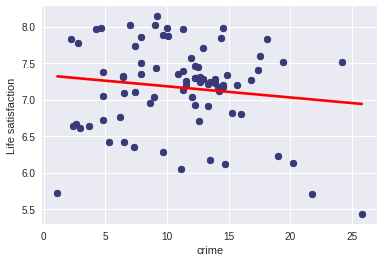

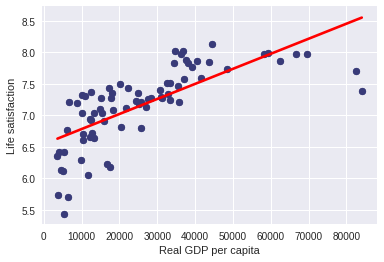

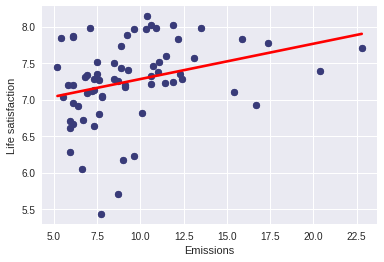

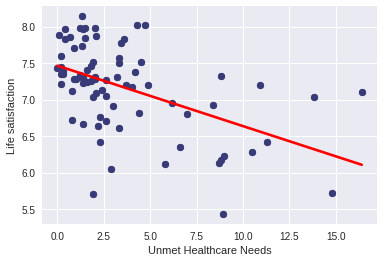

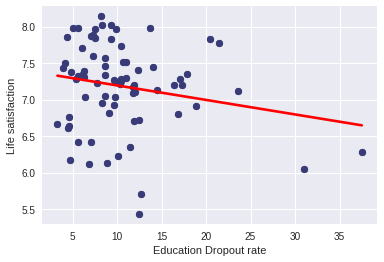

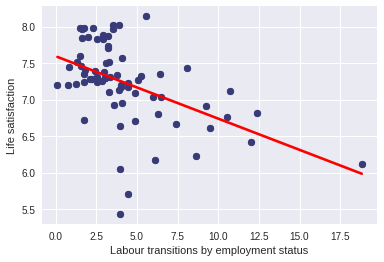

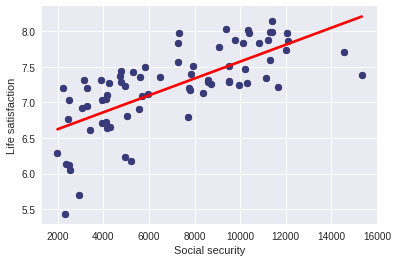

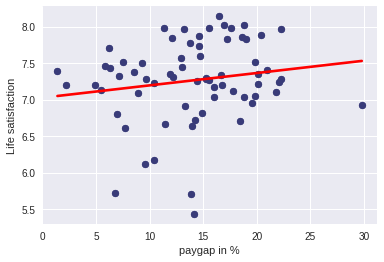

In [19]:
# Using the trend of the plot we analyse whether the variable is relevant for predicting life satisfaction.
plt.scatter(df.crime,df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and crime
sn.regplot(df.crime,df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("crime") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

plt.scatter(df['Real GDP per capita'],df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and Gdp per capita
sn.regplot(df['Real GDP per capita'],df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("Real GDP per capita") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

plt.scatter(df.Emissions,df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and amount of emmission
sn.regplot(df.Emissions,df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("Emissions") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()


plt.scatter(df.Healthcare,df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and Unmet Healthcare needs
sn.regplot(df.Healthcare,df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("Unmet Healthcare Needs") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

plt.scatter(df.educ,df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and Education dropout rate
sn.regplot(df.educ,df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("Education Dropout rate") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

plt.scatter(df.jobsecurity,df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and Labour transitions by employment status
sn.regplot(df.jobsecurity,df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("Labour transitions by employment status") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

plt.scatter(df['Social security'],df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and Social security
sn.regplot(df['Social security'],df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("Social security") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

plt.scatter(df['paygap in %'],df['life satisfaction']) ##Scatterplot with regression line for Life satisfaction and the paygap between men and women in %
sn.regplot(df['paygap in %'],df['life satisfaction'],line_kws={'color':'r'},ci = 0) #regression line
plt.xlabel("paygap in %") # label for x-axis
plt.ylabel("Life satisfaction") #label for y-axis
plt.show()

All variables show some form of upward or downward trend and all (except for 'paygap') are in line with what we expected the relationship between Life satisfaction and the other variables to be.

Crime: we see a negative relationship between crime and life stisfaction, which is to be expected.
Real GDP per capita: We see a clear upwards sloping trend of life satisfaction on Real GDP per capita, richer countries are more satisfied.
Emissions: We see an upwards sloping curve, countries that emit more are in general more satisfied (could be due to the country being richer).
Unmet healthcare needs: there seems to be a negative relationship between unmet healtcare needs and life satisfaction.
Amount of dropout from education: a slight negative relationship can be observed.
Labour transition by employment status: The regressionline is clearly downwards sloping, The more people change between employed and unemployed the less satisfied they are.
Social security: We see a clear upward sloping trend of life satisfaction the more social security increases, a country with better social security is in general more satisfied.
Paygap: there seems to be a slight positive relation between paygap and Life satisfaction. Meaning: an increase in paygap between men and women increases life satisfaction.

Next, we prepare the variables to be used by the neural network. First, we measure the mean and standard deviation of life satisfaction and standerdize all variables including life satisfaction. Afterwards, we use a formula that replaces every NaN with another normal distributed value. Afterwards, we made the life satisfaction return to its original value between 0 and 10 and created X that includes all explanatory variables and y that includes all life satisfactions.


In [20]:
meanlifsat = df['life satisfaction'].mean() # calculate mean of life satisfaction
stdlifsat = df['life satisfaction'].std()# calculate standard deviation of life satisfaction

df_x = df[['life satisfaction','crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] # create dataframe with all variables
df[['life satisfaction','crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] = (df_x-df_x.mean())/df_x.std() # standerdize variables
df = df.rename(columns={'Real GDP per capita': 'Gdp', 'Social security': 'Socsec', 'paygap in %': 'paygap', 'life satisfaction': 'Lifesat'}) # rename column names
df = df[['Lifesat','crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]]  # select correct columns

def fillNaN_with_unifrand(df):   # formula to fill NaN with random normal distributed value
    a = df.values   #create values from the df 
    m = pd.isna(a) # mask of NaNs telling whether the value is an NaN
    mu, sigma = 0, 1  # mu and sigma used in the normal distribution function
    a[m] = np.random.normal(mu, sigma, size=m.sum()) # make of every NaN a different value based on a normal distribution
    return df

df= fillNaN_with_unifrand(df) # call the formula from above the actually replace the NaNs
df['Lifesat'] = ((df['Lifesat']*stdlifsat)+ meanlifsat)*10# create values from 0-100 based on original value
df['Lifesat2'] = ((df['Lifesat'])) # create second lifesat which can be used later on 
X = df[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values  #create X values
y = df['Lifesat'].values # create outcome values
y2 =df['Lifesat2'].values # crease outocme values for diffent use later on

We decided to split the dataset into a trainingset and a test set. The training set is approximately 75% of the total datapoints. So, the test set is around 25%.

In [21]:
train = df[:65] # split test and train set 
test= df[65:89]# split test and train set 

trainy = train['Lifesat'].values   # define train set outcomes
trainX = train[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values # define train set variables

testy = test['Lifesat'].values# define test set outcomes
testX = test[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values# define test set variables


We set up the model with three layers with the tanh activation function. As this seemed to be a good predictor of some of the variables. We allow the model to choose one outcome value from 0 to 100 because these are the possible outcome of a grade between 0 and 10. Softmax, ensures that it takes the value with the highest probability as outcome. We used the Sparse top k categorical accuracy to see how ofter the outcome integer is in the top 1 of predictions. It doesn't make sense to use accuracy as we have to predict the same label as the original which is hard to do with numbers with decimals.

In [43]:
model = keras.Sequential([
    keras.layers.Dense(100, input_dim = 8, activation='tanh'), # input layer, we chose tanh function as this gives the function similar to the distribution in the graph of real gdp and life satisfaction
    keras.layers.Dense(100, activation = 'tanh'),              # hidden
    keras.layers.Dense(100, activation = 'tanh'),              # hidden
    keras.layers.Dense(101, activation = 'softmax')             # output 101 is not included so chooses between 0 and 100 So that we predict with one decimal
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)])  # define how the model should compile 
                                                     # it doesn't make sense to use accuracy as we have to predict the same label as the original which is hard to do with numbers with decimals


Here, we fit the model. we use 50 epochs, because if we used more the validation loss would increase which would suggest overfitting. At 50 epochs the validation loss also doesn't decrease so there is no underfitting visable.

In [44]:
history = model.fit(trainX,trainy,epochs=50,validation_data=(testX, testy)) # actually let the model fit the data and than test whether the trained model also works on the test dataset

Epoch 1/50
3/3 [==============================] - 1s 185ms/step - loss: 4.5868 - sparse_top_k_categorical_accuracy: 0.0308 - val_loss: 4.6075 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 0s 9ms/step - loss: 4.4210 - sparse_top_k_categorical_accuracy: 0.0923 - val_loss: 4.5478 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 0s 9ms/step - loss: 4.3047 - sparse_top_k_categorical_accuracy: 0.2615 - val_loss: 4.4884 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 0s 46ms/step - loss: 4.2036 - sparse_top_k_categorical_accuracy: 0.2769 - val_loss: 4.4332 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 0s 50ms/step - loss: 4.0977 - sparse_top_k_categorical_accuracy: 0.2615 - val_loss: 4.3798 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 6/50
3/3 [====================

We will show the results in a matrix. In the ideal scenario we would expect every observation to be on the diagonal line from top-left to bottom-right. This is not the case. But most of the cases are on the diagonal line, suggesting the predictions work. 

<AxesSubplot:>

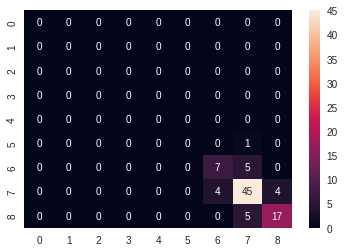

In [24]:
y_pred = (model.predict(X)).argmax(axis=1)    # use the model to make predictions 
y_pred = (y_pred/10).round()  # we round the numbers to basic 1-10 because the matrix is not readible with values 1-100
y3= (y2/10).round()# we round the numbers to basic 1-10  because the matrix is not readible with values 1-100
matrix = tf.math.confusion_matrix(y3, y_pred) # set the prediction in a model with the actual values 
sn.heatmap(matrix,annot=True) # create heatmap 

Next, we will make a graph that shows the training and validation loss from the model fit function before. I shows that although the training loss keeps decreasing the validation loss has stopped decreasing. If the validation loss would increase it would mean that the model is overfitting. 

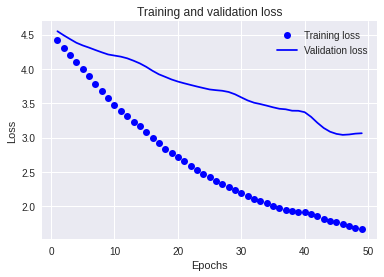

In [45]:
loss = history.history['loss'][1:]   # training loss from all different epochs
val_loss = history.history['val_loss'][1:] # validation loss from all different epochs

epochs = range(1, len(loss)+1)  # count the number of epochs

plt.plot(epochs, loss, 'bo', label='Training loss') # plot the epochs and the losses of training and validation 
plt.plot(epochs, val_loss, 'b', label='Validation loss')# plot the epochs and the losses of training and validation 
plt.title('Training and validation loss')# plot the epochs and the losses of training and validation 
plt.xlabel('Epochs')# plot the epochs and the losses of training and validation 
plt.ylabel('Loss')# plot the epochs and the losses of training and validation 
plt.legend()# plot the epochs and the losses of training and validation 
plt.show()# plot the epochs and the losses of training and validation 


We will now make a dataframe of 2017. 2017 is not measured in 2017 and we will predict it with the model we made above. First, we make a dataset of all variables in 2017 and standerdize the variables. Afterwards, we fill in any NaN in the dataframes with normal distributed values. Lastly, we create the values that will be used in the prediction and is stored in X2017. 

In [26]:
df2=realgdppc.merge(emissionpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df3=df2.merge(crime,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df4=df3.merge(socialprotpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df5=df4.merge(healthcare,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df6=df5.merge(educ,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df7=df6.merge(jobsecurity,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
dftest=df7.merge(paygap,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe

dftest2=dftest# create second set of data
dftest = dftest[dftest.year == 2017] # year to find life satisfaction from


dftest_x = dftest[['crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] # create dataframe with all variables
dftest[['crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] = (dftest_x-dftest_x.mean())/dftest_x.std() # standerdize variables
dftest = dftest.rename(columns={'Real GDP per capita': 'Gdp', 'Social security': 'Socsec', 'paygap in %': 'paygap', 'life satisfaction': 'Lifesat'}) # rename column names
dftest = dftest[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]]  # select correct columns


def fillNaN_with_unifrand(dftest):   # formula to fill NaN with random normal distributed value
    a = dftest.values   #create values from the df 
    m = pd.isna(a) # mask of NaNs telling whether the value is a NaN
    mu, sigma = 0, 1  # mu and sigma used in the normal distribution function
    a[m] = np.random.normal(mu, sigma, size=m.sum()) # make of every NaN a different value 
    return dftest

dftest= fillNaN_with_unifrand(dftest) # call the formula from above the actually replace the NaNs
X2017 = dftest.values # create varaibles to use in prediction

Next, we will use the model and the variables X2017 to predict the values of life satisfaction. 

In [27]:
y2017 = (model.predict(X2017)).argmax(axis=1)  # actually using the model to predict life satisfaction.
y2017

array([72, 78, 72, 72, 78, 72, 72, 72, 78, 72, 71, 61, 62, 72, 72, 78, 71,
       74, 73, 77, 77, 72, 73, 77, 70, 70, 70, 72, 72, 78, 73, 73, 72, 61,
       72, 74, 70, 71, 72])

In this chunk we select the Real gdp per capita from 2017 in combination with countries and add the predicted life satisfactions so that we can make a graph with the results 

In [28]:
dftest2 = dftest2[dftest2.year == 2017] # year to find life satisfaction 
dftest2['country'] = dftest2['geo'].replace(eurostat_dictionary)# add country variable was not done in this dataset 
dftestgdp = dftest2[["Real GDP per capita","country"]] # select only these two columns
dftestgdp["lifesat"] = y2017.tolist() # add the prediction lifesatisfaction to the dataframe
dfgraph = dftestgdp # rename

We make the same style graph as before but with the predicted values. Overall, It shows very similar results such that the increase in income in the low income countries effects life satisfaction a lot. At higher levels it does not seem to matter that much.

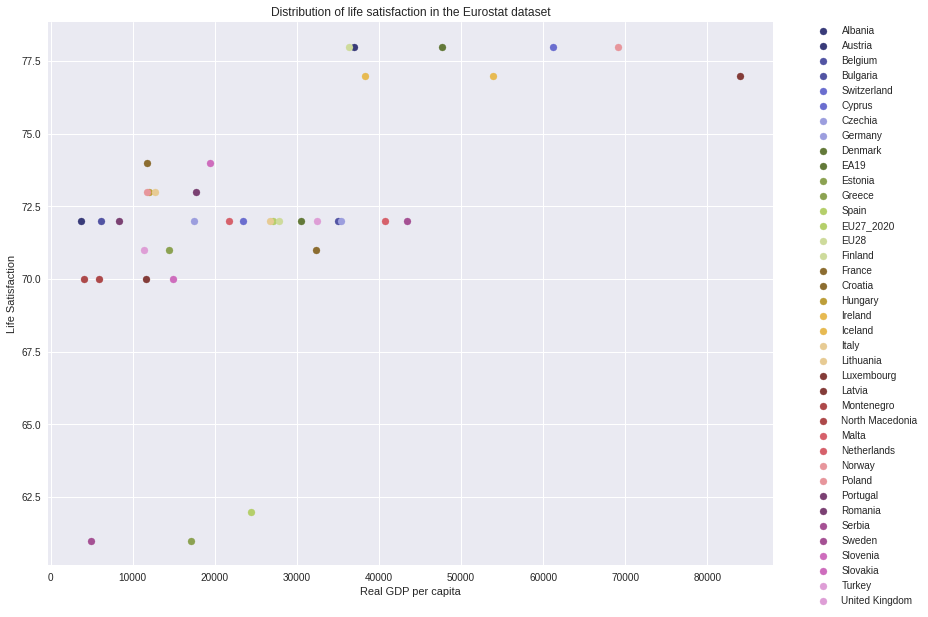

In [46]:
plt.style.use('seaborn-dark-palette')# choise of style
NUM_COLORS = 39# number of colors/countries used 

cm = plt.get_cmap('tab20b') # get the colormap 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)# rescale the colors based on the numbers to get the optimal difference in colors
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm) # handles the colormap and the colors

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)]))# makes sure that countries do not get the same color based on the number of colors

fig, (ax1) = plt.subplots(1, sharey=True, sharex=True,figsize=(13,10)) # create plotsize


for country in dfgraph.country.unique():# for every country 
    mask = (dfgraph.country == country) # test and make mask if the row is a country value
    ax1.scatter(dfgraph[mask]['Real GDP per capita'], dfgraph[mask]['lifesat'], label = country)# set the x and y and group per country
   


ax1.set_xlabel('Real GDP per capita')# name x-axis
ax1.set_ylabel('Life Satisfaction')# name y-axis
ax1.set_title('Distribution of life satisfaction in the Eurostat dataset') # set title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.); # settings for legend

Lastly, we show the results as descriptive statistics. It shows that the average life satisfaction is 7.2 and the standard deviation is around 4.05 in 2017. 

In [30]:
y2017 = pd.DataFrame(y2017)
y2017.describe()


,0
count,39.00000
mean,72.25641
std,4.05695
min,61.00000
25%,71.50000
50%,72.00000
75%,73.50000
max,78.00000


## show with self made numbers that method works. 

Next, we will make made up variable and a model to show that the model works. First, we create 8 variables based on a normal distribution and afterwards use these to create an outcome variable. That has the same average and std as the original life satisfaction. Afterwards create a dataset that includes all explanory variables. 

In [31]:
var1 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var2 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var3 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var4 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var5 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var6 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var7 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var8 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 

In [32]:
outcome = var1*6+var2*2+var3*9+var4*20+var5*1+var6*3+var7*18+var8*5 # create outcome variable 
outcome = (((outcome-outcome.mean())/outcome.std()*stdlifsat) + meanlifsat)*10# standerdize outcome variable and use mean and standard deviation from life statisfaction

In [33]:
data = np.concatenate((np.matrix(outcome).T,np.matrix(var1).T,np.matrix(var2).T,np.matrix(var3).T,np.matrix(var4).T,np.matrix(var5).T,np.matrix(var6).T,np.matrix(var7).T,np.matrix(var8).T),axis=1) # merge arrays columnwise by using axis=1

Again, we create a training and test dataset with 75% of the observation used for training and 25% for testing. 

In [34]:
X2 = data[:,[1,2,3,4,5,6,7,8]] # create variable dataset
y2 = data[:,[0]]# create outcome dataset
train2 = data[:75] # create training dataset
test2= data[75:101]# create testing dataset

trainy2 = train2[:,[0]]# create training outcome dataset
testy2 = test2[:,[0]]# create testing outcome dataset

trainX2 = train2[:,[1,2,3,4,5,6,7,8]]# create training variables dataset
testX2 = test2[:,[1,2,3,4,5,6,7,8]]# create testing variables dataset

We, use the same method as before, including the 50 epochs. 

In [35]:
history = model.fit(trainX2,trainy2,epochs=50,validation_data=(testX2, testy2)) # fit the model with new test and training sets 

Epoch 1/50
3/3 [==============================] - 1s 144ms/step - loss: 5.2838 - sparse_top_k_categorical_accuracy: 0.0667 - val_loss: 4.8019 - val_sparse_top_k_categorical_accuracy: 0.0400
Epoch 2/50
3/3 [==============================] - 0s 41ms/step - loss: 5.1867 - sparse_top_k_categorical_accuracy: 0.0667 - val_loss: 4.7021 - val_sparse_top_k_categorical_accuracy: 0.0400
Epoch 3/50
3/3 [==============================] - 0s 9ms/step - loss: 5.0340 - sparse_top_k_categorical_accuracy: 0.0667 - val_loss: 4.5810 - val_sparse_top_k_categorical_accuracy: 0.0400
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 4.8295 - sparse_top_k_categorical_accuracy: 0.0667 - val_loss: 4.4528 - val_sparse_top_k_categorical_accuracy: 0.0400
Epoch 5/50
3/3 [==============================] - 0s 13ms/step - loss: 4.6140 - sparse_top_k_categorical_accuracy: 0.0667 - val_loss: 4.3228 - val_sparse_top_k_categorical_accuracy: 0.0400
Epoch 6/50
3/3 [==============================] - 0s 45

we will show the results in a matrix. In the ideal scenario we would expect every observation to be on the diagonal line from top-left to bottom-right. This is not the case. But most of the cases are on the diagonal line, suggesting the predictions work. 

<AxesSubplot:>

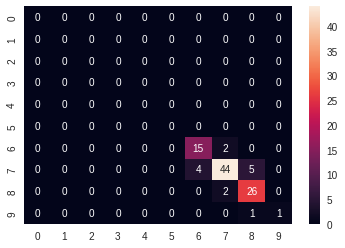

In [36]:
y_pred2 = (model.predict(X2)).argmax(axis=1)# use the model to make predictions 
y_pred2 = (y_pred2/10).round()
y2= (y2/10).round()
matrix = tf.math.confusion_matrix(y2, y_pred2)# set the prediction in a model with the actual values 
sn.heatmap(matrix,annot=True)

Next, we will make a graph that shows the training and validation loss from the model fit function before. We shows that although the training loss keeps decreasing the validation loss has stopped decreasing. If the validation loss would increase it would mean that the model is overfitting. 

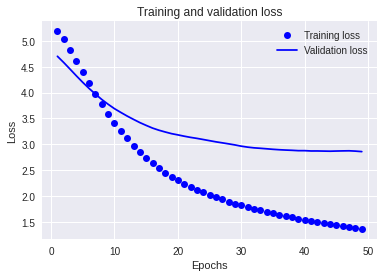

In [37]:
loss = history.history['loss'][1:]# training loss from all different epochs
val_loss = history.history['val_loss'][1:]# validation loss from all different epochs 

epochs = range(1, len(loss)+1) # count the number of epochs

plt.plot(epochs, loss, 'bo', label='Training loss') # plot the epochs and the losses of training and validation 
plt.plot(epochs, val_loss, 'b', label='Validation loss') # plot the epochs and the losses of training and validation 
plt.title('Training and validation loss') # plot the epochs and the losses of training and validation 
plt.xlabel('Epochs') # plot the epochs and the losses of training and validation 
plt.ylabel('Loss') # plot the epochs and the losses of training and validation 
plt.legend() # plot the epochs and the losses of training and validation 
plt.show() # plot the epochs and the losses of training and validation 


# Bayesian Model

we will use an baysian model to predict the estimates of the tanh funtion of the correlation between real gdp per capita and life satisfaction. This includes the starting position which we called "b". The stretch of he function which is "a" and the height of the formula which is determined by "c". We create a model that tries used these parameters as imputs and tries to find the best fit with the actual values of life satisfaction.

In [38]:
t = np.arange(0,88,1) # arange the number of t which is goes to 88 


with pm.Model() as exponential_model:  # create model
    a = pm.HalfNormal('a',0.1)    #create the variable that stretches the tahn formula
    b = pm.Normal('b',mu = 50, sd = 10) # create starting variable on basis of original graph before 
    c = pm.Normal('c',mu = 10, sd = 3) # create the size of the effectiveness of the tanh formula
    y = np.tanh(t*a)*c+b  # actual tanh formula
    eps = pm.HalfNormal('eps',1)  # create eps 
    lifesat = pm.Normal('lifesat', mu = y,\
                             sigma = eps, observed = df.Lifesat) # create variable lifesat with the observed life satisfaction data from before
    prior_predictive = pm.sample_prior_predictive(samples=50)  # use 50 samples

Here, we tune the model 3000 times, the tuning is 3000 because we increase the table to increase the probability that the acceptance probability matches the target. 

In [39]:
with exponential_model:
    trace = pm.sample(tune=2500)     # tune the model with 3000 tunes 
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c, b, a]


Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 85 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6087037977617353, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9190542094455735, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Next, we show a traceplot to show the traces of the different parameters.

array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

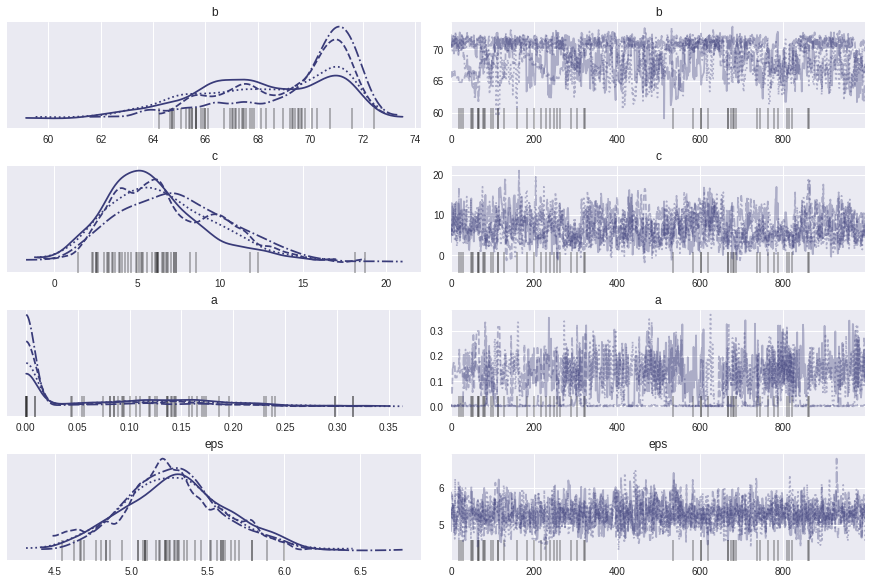

In [40]:
pm.traceplot(trace)  # show the trace plot

In [41]:
az.summary(trace) # give summary of the trace 



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,68.888,2.518,64.153,72.303,0.366,0.262,51.0,423.0,1.06
c,6.680,3.330,1.215,13.260,0.279,0.198,151.0,1163.0,1.02
a,0.076,0.084,0.000,0.222,0.013,0.009,46.0,761.0,1.06
eps,5.275,0.331,4.621,5.888,0.015,0.010,499.0,340.0,1.01


The r hat is higher than 1 for the variables. This is probably due to slight problems during sampling. It can indicate that the model has failed to converge. To see if the variables make sense the estimates are used in the graph below. 

We will use the average of the parameters to show the function that the baysian model found to be closest to the actual observations. This graph does match the distribution quite well as the first income jumps have a big effect on life satisfaction. 

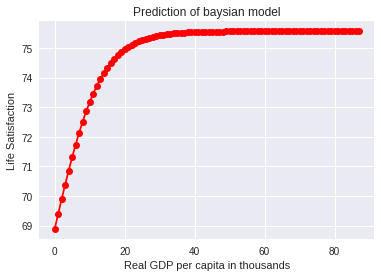

In [42]:
ina = np.arange(0,88,1)  # create the numbers on x-axis
out = np.tanh(ina*0.076)*6.68+68.888 #create outcome based on the numbers found by the bayesian model


plt.plot(ina, out, color = 'red', marker = "o") # plot x and outcome
plt.title("Prediction of baysian model") # print title
plt.xlabel("Real GDP per capita in thousands") # set x-label
plt.ylabel("Life Satisfaction") # set y-label
plt.show() # show graph

# Discussion and conclusion (0.5 points)



In conclusion we found that the estimates for life satisfaction in 2017 are on average 7.2, with a standard deviation of around 4. They also show a similar distribution with real gdp per capita. Which we tried to find in with the baysian model. It estimated the the correlation between life satisfaction times 10 and real gdp per capita is captured by this regression : tanh(gdp*0.076)*6.68+68.888. 

This model only uses the data of 2013 and 2018 and has therefore relatively little training data to learn how to predict life satisfaction. Further research could include more training data to improve the accuracy of the model. Moreover, this model was trained using data from the eurostat database. Therefore, it is probably bad at predicting life satisfaction in other parts of the world such as Afrika. A more robust analysis on all countries is an opportunity of further research, but is probably more difficult due to hard-to-measure cultural differences. 